# Measuring BMI in OpenSAFELY-TPP
This report describes how BMI can be identified in the OpenSAFELY-TPP database, and the strengths and weaknesses of the methods. BMI has been identified as a risk factor for clinical outcomes in patients with COVID-19 [1-3]. Electronic Health Records (EHR) hold significant potential for studying the association between BMI and COVID-19. This depends on the validity, completeness, and currency of BMI information that is available in or can be derived from EHR. Thus, this study aims to describe and compare methods for identifying BMI in EHR. This is a living document that will be updated to reflect changes to the OpenSAFELY-TPP database and the patient records within.

## OpenSAFELY
OpenSAFELY is an analytics platform for conducting analyses on Electronic Health Records inside the secure environment where the records are held. This has multiple benefits: 

* We don't transport large volumes of potentially disclosive pseudonymised patient data outside of the secure environments for analysis.
* Analyses can run in near real-time as records are ready for analysis as soon as they appear in the secure environment.
* All infrastructure and analysis code is stored in GitHub repositories, which are open for security review, scientific review, and re-use.

A key feature of OpenSAFELY is the use of study definitions, which are formal specifications of the datasets to be generated from the OpenSAFELY database. This takes care of much of the complex EHR data wrangling required to create a dataset in an analysis-ready format. It also creates a library of standardised and validated variable definitions that can be deployed consistently across multiple projects. 

The purpose of this report is to describe derivations of BMI, their relative strengths and weaknesses, and the scenarios in which they are best deployed. It will also describe potential future definitions that have not yet been implemented.

## Available Records

OpenSAFELY-TPP runs inside TPP's data centre which contains the primary care records for all patients registered at practices using TPP's SystmOne Clinical Information System. This data centre also imports external datasets from other sources, including A&E attendances and hospital admissions from NHS Digital's Secondary Use Service, and death registrations from the ONS. More information on available data sources can be found within the [OpenSAFELY documentation](https://docs.opensafely.org/data-sources/intro/). 

## Methods
We define four variable derivations: "CTV3-calculated BMI" (derived from CTV3 height and weight), "SNOMED-calculated BMI" (derived from SNOMED height and weight), "SNOMED-recorded BMI" (derived from directly recorded BMI values in SNOMED), and "composite BMI" (derived from CTV3-calculated BMI or SNOMED-recorded BMI, and implemented using most_recent_bmi function).

* Calculated BMI refers to BMI calculated from height and weight measurements. Previous height records are carried over to the future to compute BMI with the assumption that there is little variation in an individual's height in adulthood. New BMI records are only calculated when there is a new weight measurement, as there can be greater variation in weights. Height and weight measurements are derived using two sets of codelists, so we compare the derivations created using each of these codelists: 
  * CTV3-calculated BMI, which uses CTV3 height ("XM01E", "229..") and weight ("X76C7", "22A..") codes used in the OpenSAFELY-TPP backend.
  * SNOMED-calculated BMI, which uses SNOMED [height](https://www.opencodelists.org/codelist/opensafely/height-snomed/3b4a3891/) and [weight](https://www.opencodelists.org/codelist/opensafely/weight-snomed/5459abc6/) codes.
* SNOMED-recorded BMI refers to SNOMED-coded events of BMI. 
* Composite BMI refers to the canonical definition used in the OpenSAFELY backend using the [`most_recent_bmi()`](https://docs.opensafely.org/study-def-variables/#cohortextractor.patients.most_recent_bmi) function, which returns patients' most recent BMI (in the defined period) either calculated from CTV3-coded weight and height measurements or, where they are not available, from SNOMED-recorded BMI values.

For each registered patient aged 18 to 110 at the time of measurement, we extract up to ten latest BMI measurements (going back from 1st May 2022) for each method of derivation.

To evaluate how well each of these derivations are populated, we count the number of patients with each type of BMI measurement, as well as the number of measurements themselves. We also examine the plausibility of each derivation by looking at the distribution of measurements and counting values out of the expected range. To evaluate how frequently the BMI derivations are recorded, we track the number of new measurements recorded over time and average time between updates.

We examine trends across the whole population and by each of the following demographic and clinical subgroups to detect any inequalities.

Demographic covariates:
* Age band 
* Sex
* Ethnicity 
* Region
* IMD

Clinical covariates:
* Dementia
* Diabetes
* Learning disability

In the empirical cumulative distribution function charts, steps were deferred until there were at least 5 observations, then midpoint rounding was applied. In all other analyses, any counts below 6 were redacted, and all other values were rounded to the nearest 5. 

## Results

In [29]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import numpy as np
import os
import seaborn as sns
from IPython.display import display, Markdown

pd.options.mode.chained_assignment = None

%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 12]

path = "../output/validation/formatted_tables"
path2 = "../output/validation/tables"

ethnicity_dict = {
    "True": "White",
    "1": "White",
    "2": "Mixed",
    "3": "Asian",
    "4": "Black",
    "5": "Other",
    np.nan: "Unknown",
    "0": "Unknown",
}

imd_dict = {
    "False": "Unknown",
    "0": "Unknown",
    "1": "1 Most deprived",
    "True": "1 Most deprived",
    "2": "2",
    "3": "3",
    "4": "4",
    "5": "5 Least deprived",
}

In [30]:
def display_ct(unit, ethnicity_dict, imd_dict):
    df_ct = pd.read_csv(f"{path}/{unit}.csv")
    df_ct.loc[df_ct["category"] == "population", "sort"] = 1
    
    # Rename subcategories 
    df_ct.loc[df_ct["category"] == "ethnicity", "subcategory"] = df_ct["subcategory"].map(ethnicity_dict)
    df_ct.loc[df_ct["category"] == "imd", "subcategory"] = df_ct["subcategory"].map(imd_dict)
    
    # Clean category
    df_ct["category"] = df_ct["category"].apply(lambda x: x.replace("_", " ").title())
    df_ct["subcategory"] = df_ct["subcategory"].apply(lambda x: x.replace("_", " ").title())
    df_ct.loc[df_ct["category"] == "Imd", "category"] = "IMD"
    
    # Sort 
    df_ct = df_ct.sort_values(
        by=["sort","category","subcategory"]
    ).drop(columns=["sort"]).rename(
        columns={
            "category":"Category",
            "subcategory":"Subcategory"
        }
    ).set_index(["Category","Subcategory"])
    
    df_ct = df_ct.replace("-",np.nan)
        
    if unit == "measurement_counts":
        # Create percentages
        for col in df_ct.columns:
            df_ct[col+'_pct'] = round((df_ct[col].astype(float).div(float(df_ct[col][0])))*100,1)
            
            # NAN control
            df_ct[col] = df_ct[col].fillna(-1)
            # Combine count and percentage columns
            df_ct[col]=df_ct[col].astype(float).astype(int).apply(lambda x: "{:,.0f}".format(x))
            df_ct[col] = df_ct[col].astype(str) + " (" + df_ct[col+'_pct'].astype(str) + ")" 
            df_ct = df_ct.drop(columns=[col+'_pct'])
            df_ct.loc[df_ct[col] == "-1 (nan)", col] = "- (-)"
            
        # Rename column names
        df_ct = df_ct.rename(
            columns={
                "derived_bmi_num_measurements":"Composite BMI",
                "recorded_bmi_num_measurements":"SNOMED-recorded BMI",
                "backend_computed_bmi_num_measurements":"CTV3-calculated BMI",
                "computed_bmi_num_measurements":"SNOMED-calculated BMI",
            }
        )

    display(df_ct)

### Count of Measurements

Around 22 million patients who have been registered in OpenSAFELY-TPP have each derivation of BMI definition. Across all records, each patient has, on average, around 6 or 7 BMI measurements in their records. Hence, the 10 most recent measurements for each derivation are extracted per patient.

Composite BMI, which is a combination of CTV3-calculated and SNOMED-recorded BMIs, is the most well-populated with 112.2 million measurements. SNOMED-recorded BMI is second best with 104.7 million and the two calculated BMI derivations each have around 84 million records.

In [31]:
display_ct("measurement_counts", ethnicity_dict, imd_dict)

Composite BMI  \
Category            Subcategory                               
Population          All                       7,905 (100.0)   
Age Band            18-29                          40 (0.5)   
                    30-39                          80 (1.0)   
                    40-49                          45 (0.6)   
                    50-59                          60 (0.8)   
                    60-69                          45 (0.6)   
                    70-79                          60 (0.8)   
                    80+                            40 (0.5)   
                    Missing                    7,535 (95.3)   
Dementia            False                         615 (7.8)   
                    True                              - (-)   
Diabetes            False                         615 (7.8)   
                    True                              - (-)   
Ethnicity           Asian                          90 (1.1)   
                    Black                          60 (0.8)   
                    Mixed                         180 (2.3)   
                    Other                          40 (0.5)   
                    White                         245 (3.1)   
IMD                 1 Most Deprived                90 (1.1)   
                    2                             140 (1.8)   
                    3                             170 (2.2)   
                    4                             130 (1.6)   
                    5 Least Deprived               75 (0.9)   
                    Unknown                        15 (0.2)   
Learning Disability False                         615 (7.8)   
                    True                              - (-)   
Region              East Midlands                  60 (0.8)   
                    East Of England                35 (0.4)   
                    London                         85 (1.1)   
                    North East                     25 (0.3)   
                    North West                     45 (0.6)   
                    South East                    120 (1.5)   
                    West Midlands                  15 (0.2)   
                    Yorkshire And The Humber       20 (0.3)   
Sex                 F                             260 (3.3)   
                    M                             360 (4.6)   

                                             SNOMED-recorded BMI  \
Category            Subcategory                                    
Population          All                            6,910 (100.0)   
Age Band            18-29                               55 (0.8)   
                    30-39                               50 (0.7)   
                    40-49                               30 (0.4)   
                    50-59                               40 (0.6)   
                    60-69                               60 (0.9)   
                    70-79                               45 (0.7)   
                    80+                                125 (1.8)   
                    Missing                         6,510 (94.2)   
Dementia            False                              680 (9.8)   
                    True                                   - (-)   
Diabetes            False                              680 (9.8)   
                    True                                   - (-)   
Ethnicity           Asian                               95 (1.4)   
                    Black                               40 (0.6)   
                    Mixed                              145 (2.1)   
                    Other                               50 (0.7)   
                    White                              355 (5.1)   
IMD                 1 Most Deprived                    130 (1.9)   
                    2                                  150 (2.2)   
                    3                                  130 (1.9)   
                    4                                  120 (1.7)   
                   

### Frequency of New Measurements

For patients with more than one BMI measurement, the frequency of measurement was computed to describe the frequency of measurements. The CDF plots below show the distribution of repeat measurements across the difference in measurement dates. An empirical Cumulative Distribution Function (CDF) describes the distribution of a measure across the sample. The value of the function at a specified value of the measure is the proportion of observations that are less than or equal to that value. 

The plot shows a time difference of 3,600 days (approximately 10 years). Across all four derivations, around 60% of patients with repeat measurements have a follow up measurement within 5 years and greater than 80% of such patients have a follow up measurement within 10 years.

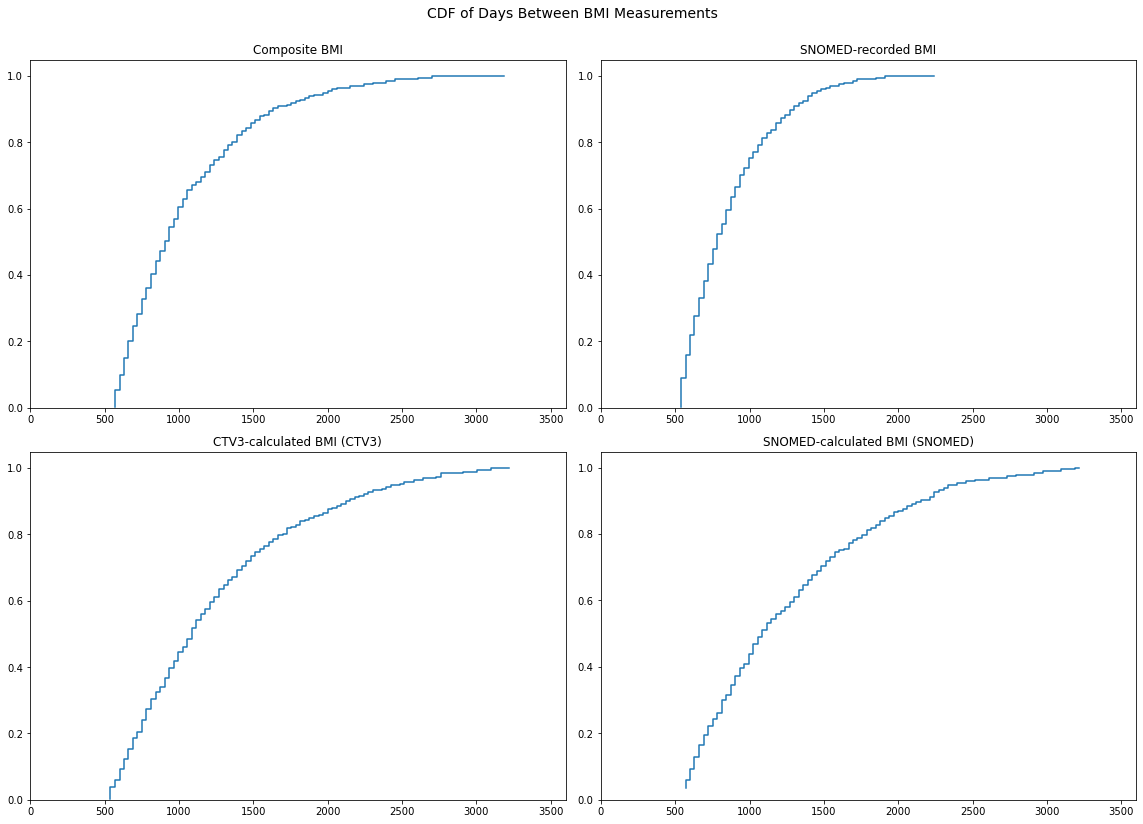

In [32]:
i = 0
N = 4
cols = 2
rows = int(math.ceil(N / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()

for bmi in ["derived_bmi", "recorded_bmi", "backend_computed_bmi", "computed_bmi"]:
    file = f"{path2}/{bmi}/{bmi}_date_diff_cdf_data.csv"
    df_temp = pd.read_csv(file,index_col=0)
    definition = df_temp.columns[0]
    ax = fig.add_subplot(gs[i]) 
    ax.step(x = definition, y = 'cdf', data=df_temp)
    plt.xlim(0,3600)
    plt.ylim(bottom=0)
    
    # Rename labels 
    if definition == "derived_bmi_date_diff":
        definition2 = "Composite BMI"
    elif definition == "recorded_bmi_date_diff": 
        definition2 = "SNOMED-recorded BMI"
    elif definition == "computed_bmi_date_diff":
        definition2 = "SNOMED-calculated BMI (SNOMED)"
    else:
        definition2 = "CTV3-calculated BMI (CTV3)"
    
    ax.set_title(f'{definition2}')
    i += 1

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("CDF of Days Between BMI Measurements", fontsize=14)
plt.show()

### Distributions

The boxplots below summarise the distributions of each BMI definition across the total population and by demographic and clinical subgroups. The distributions appear to be similar across the different derivations, with a median of 27 across the total population. 

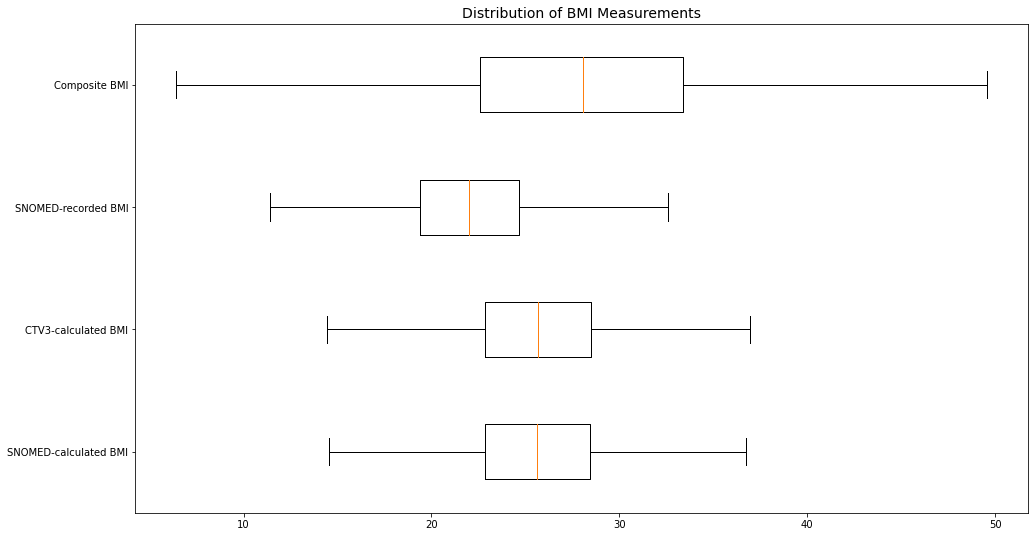

In [33]:
li_all = []

for bmi in ["computed_bmi", "backend_computed_bmi", "recorded_bmi", "derived_bmi"]:
    file = f"{path}/{bmi}_distribution.csv"
    df_temp = pd.read_csv(file)
    df_temp = df_temp.loc[df_temp["category"] == "population"]
    # Pull out BMI label
    df_temp["label"] = file.rsplit('/', 1)[-1].rsplit('_', 1)[0]
    # Rename labels 
    df_temp.loc[df_temp["label"] == "derived_bmi", "label"] = "Composite BMI"
    df_temp.loc[df_temp["label"] == "recorded_bmi", "label"] = "SNOMED-recorded BMI"
    df_temp.loc[df_temp["label"] == "computed_bmi", "label"] = "SNOMED-calculated BMI"
    df_temp.loc[df_temp["label"] == "backend_computed_bmi", "label"] = "CTV3-calculated BMI"
    # Rename columns to statistics necessary to plot
    df_temp = df_temp.rename(columns={
        "lower_extreme": "whislo",
        "upper_extreme": "whishi",
        "q25": "q1",
        "median": "med",
        "q75": "q3"
    }).drop(columns=["category", "subcategory"]).reset_index(drop=True)
    
    # Create dictionary with statistics to plot
    dict_temp = {}
    for col in df_temp.columns:
        dict_temp[col] = df_temp[col][0]
    # Append dictionaries together
    li_all.append(dict_temp)

# Plot the figures
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), sharey=True)
axes.bxp(li_all, showfliers=False, vert=False)
plt.title(f"Distribution of BMI Measurements",fontsize=14)
plt.show()

In [34]:
def distribution_by_group(category, code_dict=''):
    i = 0
    N = 4
    cols = 2
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    
    for bmi in ["derived_bmi", "recorded_bmi", "backend_computed_bmi", "computed_bmi"]:
        file = f"{path}/{bmi}_distribution.csv"
        df_temp = pd.read_csv(file)
        df_temp = df_temp.loc[(df_temp["subcategory"] != "missing") & (df_temp["subcategory"] != "Unknown")]
        df_temp = df_temp.loc[df_temp["category"] == f"{category}"].drop(columns=["category"]).rename(columns={"subcategory":"label"})
        # Rename columns to statistics necessary to plot
        df_temp = df_temp.rename(columns={
            "lower_extreme": "whislo",
            "upper_extreme": "whishi",
            "q25": "q1",
            "median": "med",
            "q75": "q3"
        }).reset_index(drop=True)
        
        if (category == "ethnicity") | (category == "imd"):
            df_temp["label"] = df_temp["label"].map(code_dict)
            
        if (category == "learning_disability") | (category == "diabetes") | (category == "dementia"):
            df_temp.loc[df_temp["label"] == "1", "label"] = "True"
            
        li_all = []
        # Create dictionary with statistics to plot
        for index, row in df_temp.iterrows():
            li_all.append(row.to_dict())
        definition  = file.rsplit('/', 1)[-1].rsplit('_', 1)[0]
        
        # Rename labels 
        if definition == "derived_bmi":
            definition = "Composite BMI"
        elif definition == "recorded_bmi": 
            definition = "SNOMED-recorded BMI"
        elif definition == "computed_bmi":
            definition = "SNOMED-calculated BMI"
        else:
            definition = "CTV3-calculated BMI"
            
        # Create category for title
        cat = category.replace("_"," ").title()
        if cat == "Imd":
            cat = "IMD"
        
        # Plot the figures
        ax = fig.add_subplot(gs[i])
        ax.bxp(li_all, showfliers=False, vert=False)
        ax.set_title(f"{definition}")
        i += 1
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"Distribution by {cat}", fontsize=14)
    plt.show()

Middle aged (50-69) patients have the highest medians among the different age groups, females have a lower median and more variation than males, Black patients have higher medians than other ethnic groups, and BMI is incrementally higher in more deprived IMD areas. People with diabetes and learning disabilities tend to have higher BMI than those who do not have these conditions, while dementia patients tend to have a lower BMI than those without dementia. 

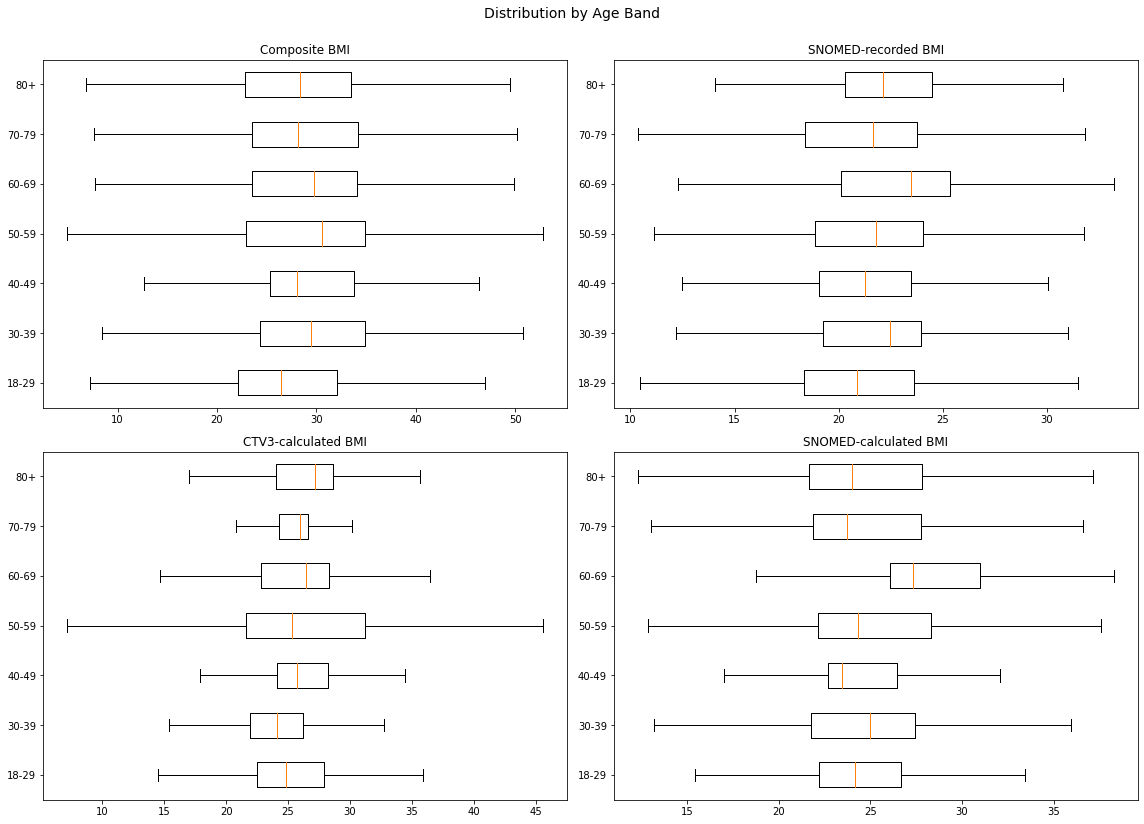

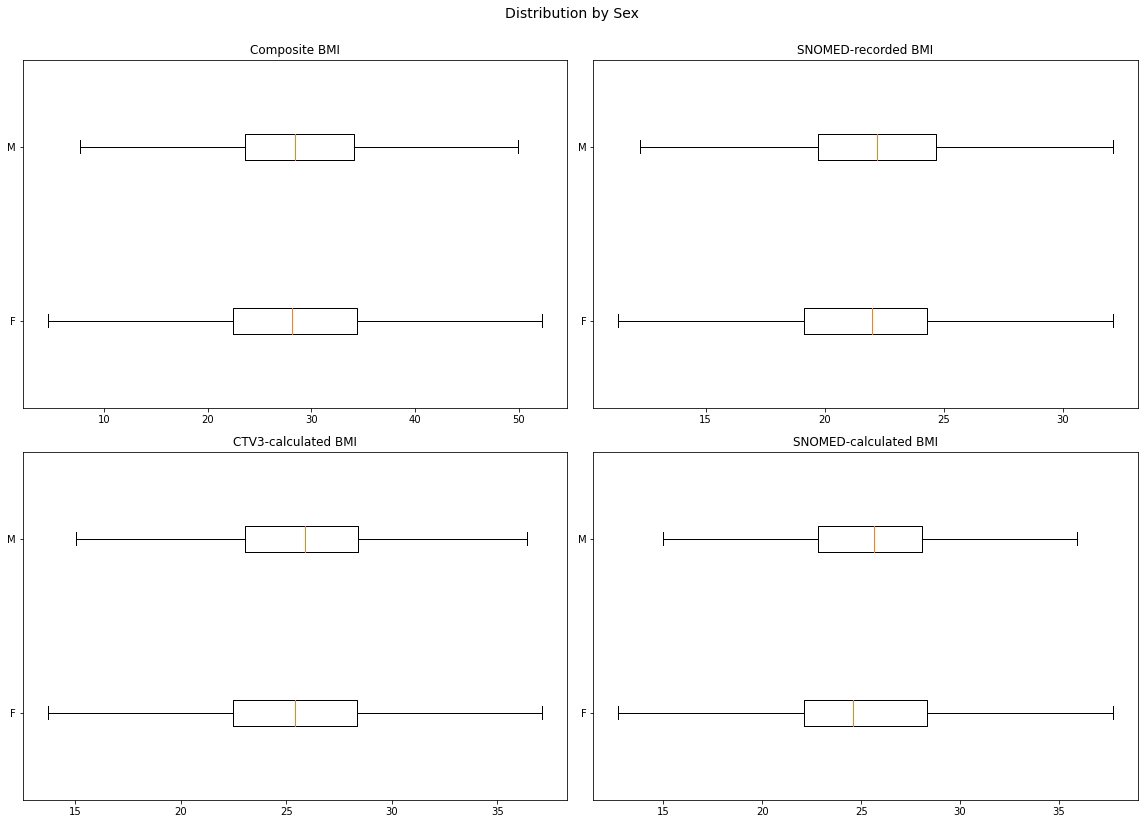

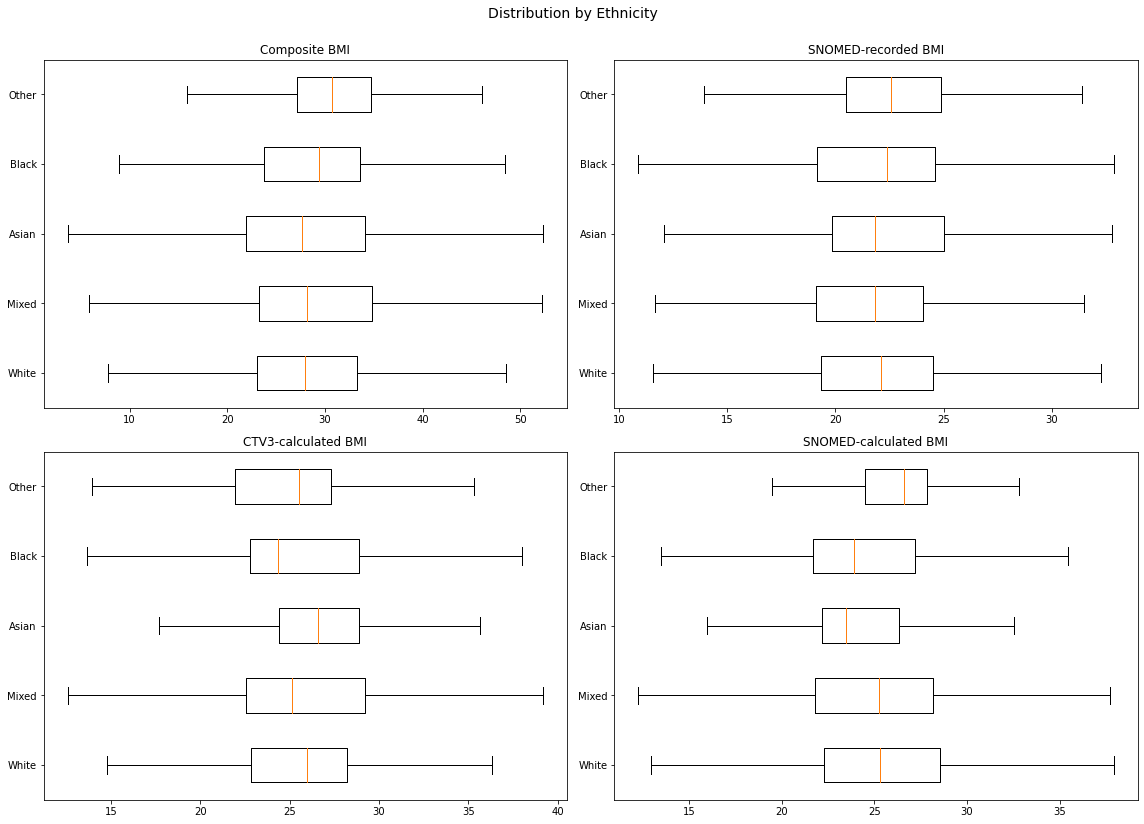

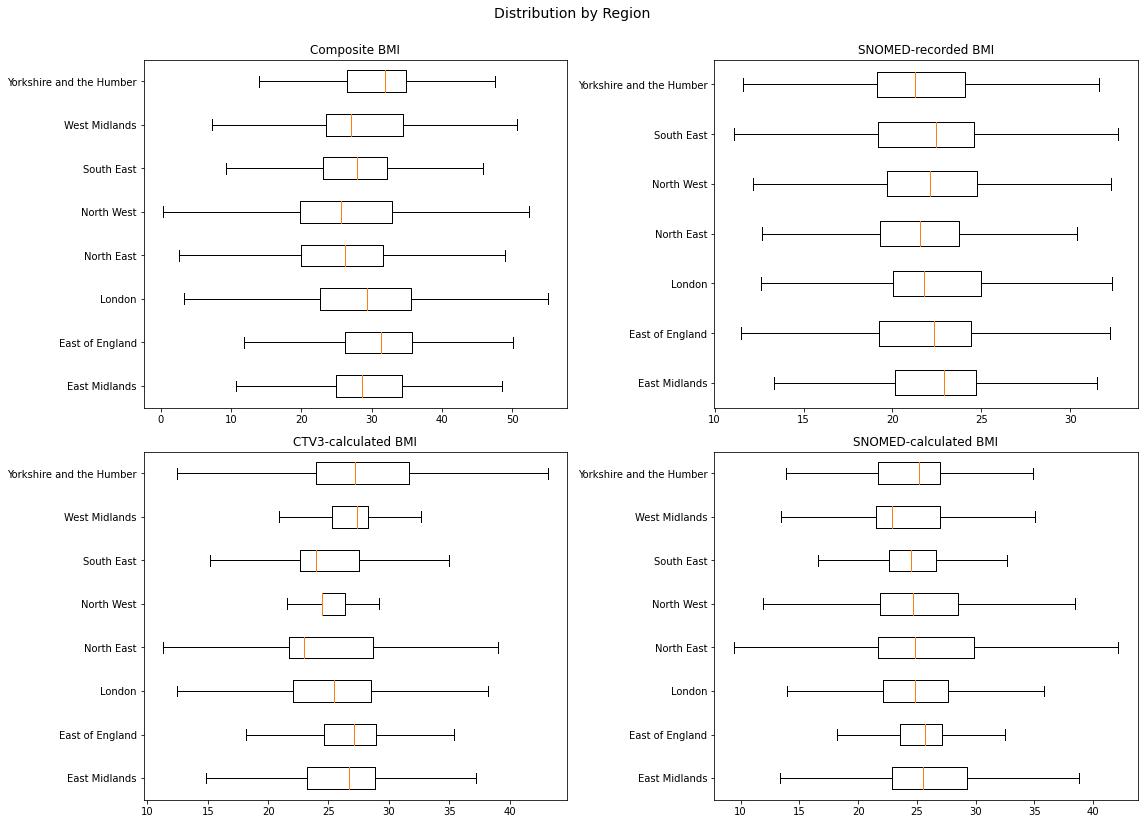

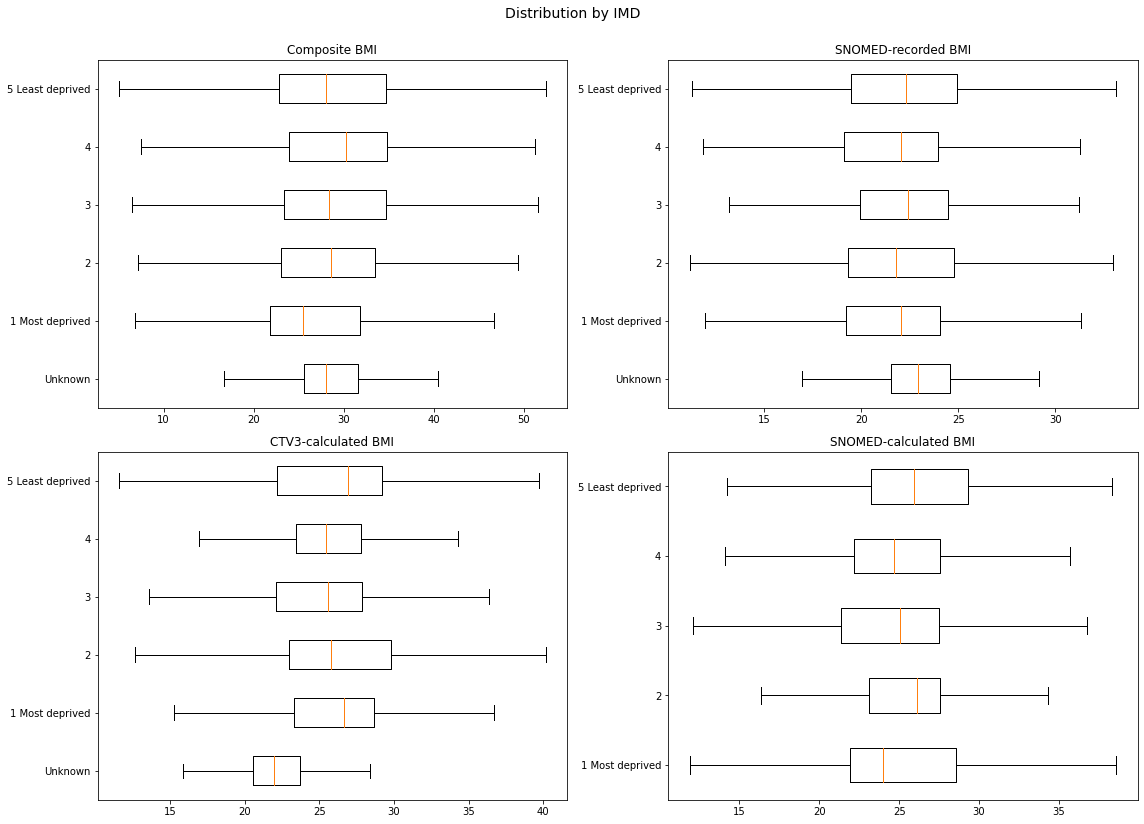

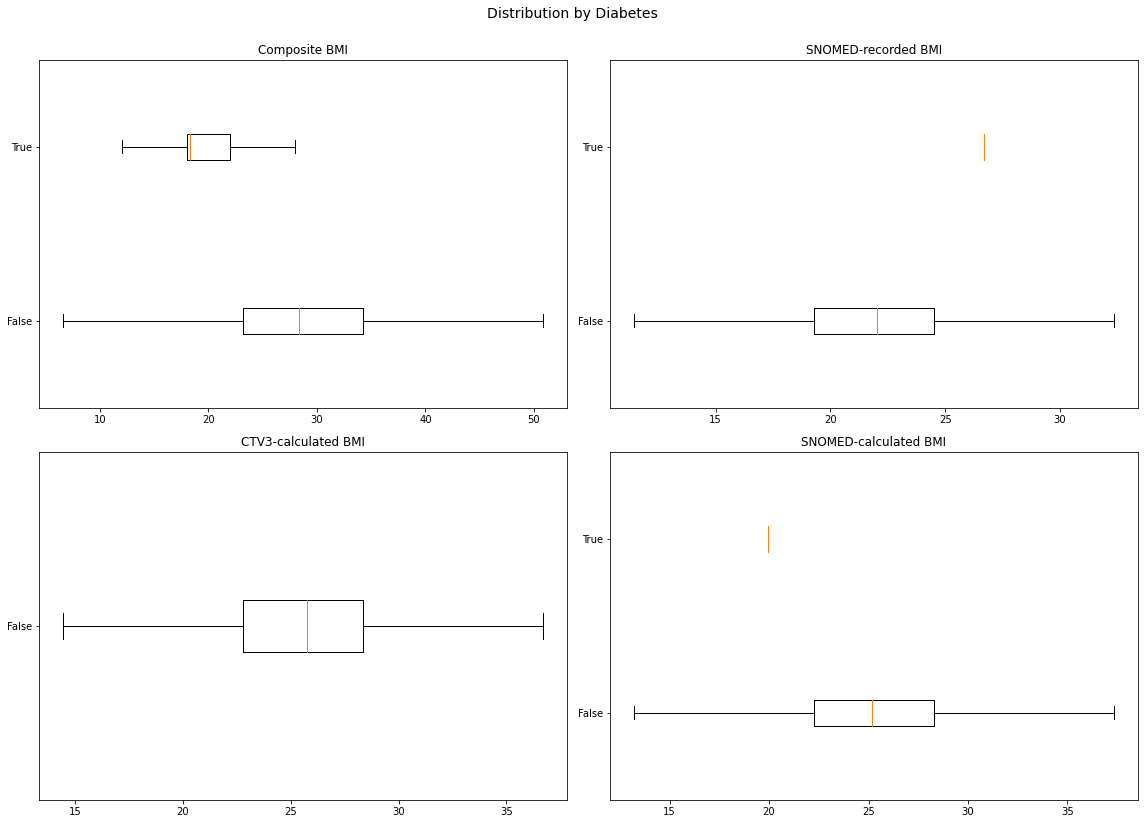

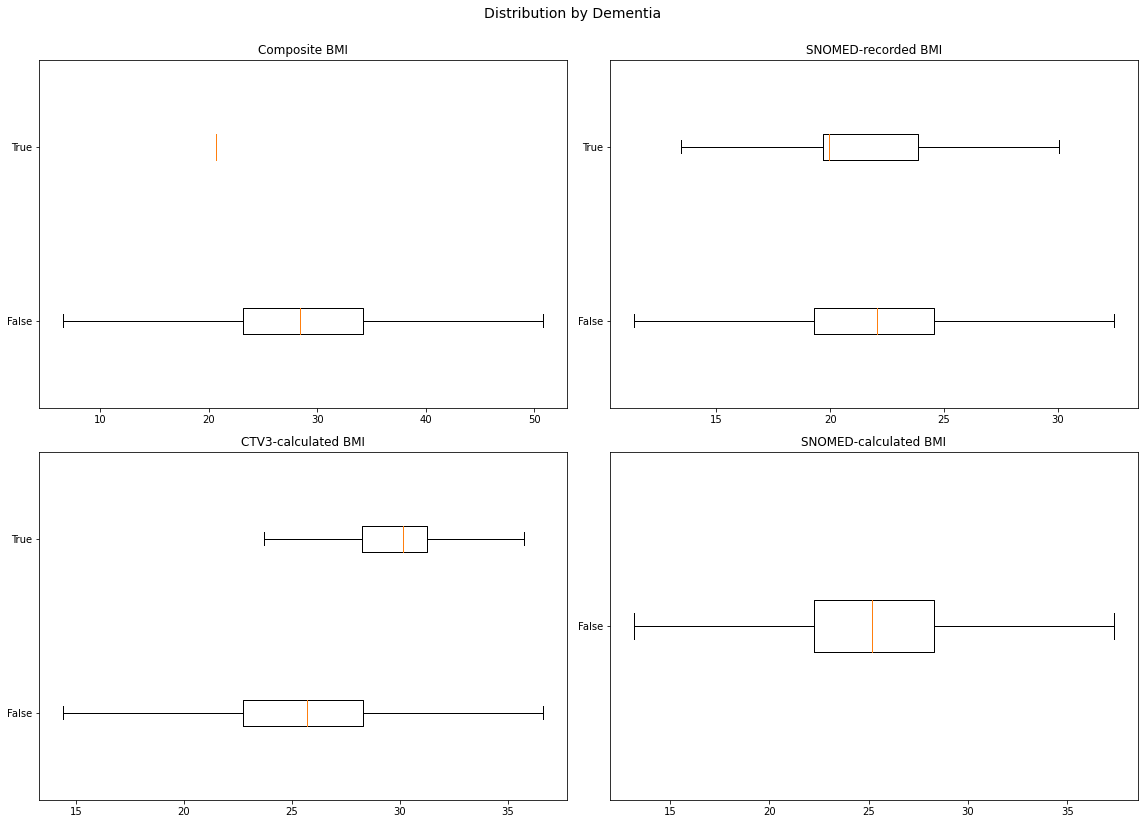

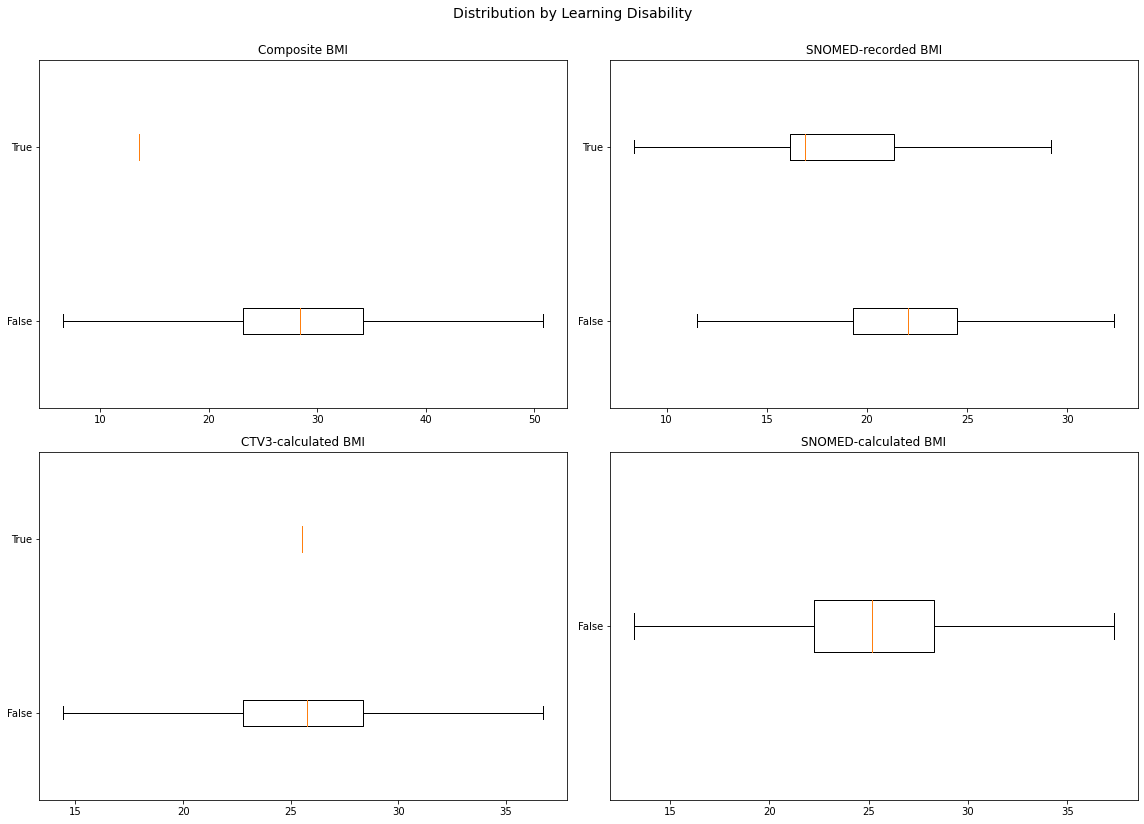

In [35]:
distribution_by_group("age_band")
distribution_by_group("sex")
distribution_by_group("ethnicity", ethnicity_dict)
distribution_by_group("region")
distribution_by_group("imd", imd_dict)
distribution_by_group("diabetes")
distribution_by_group("dementia")
distribution_by_group("learning_disability")

### Records Over Time

The charts below show the number of new BMI records by month from January 2015 to April 2022. Generally, there was an increase in the number of new records from 2015 to 2019 from around 400,000 to greater than 800,000. Across all definitions and subgroups, there is a steep drop around March 2020 at the start of the COVID-19 pandemic, likely due to the reduction in primary care services. There is gradual recovery in the number of new records from July 2020 onward.

In [36]:
def plot_over_time(unit):
    i = 0
    N = 4
    cols = 2
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    
    for bmi in ["derived_bmi", "recorded_bmi", "backend_computed_bmi", "computed_bmi"]:
        file = f"{path}/{bmi}_{unit}_over_time.csv"
        if "high" not in file:
            df_in = pd.read_csv(file)
            definition  = file.rsplit('/', 1)[-1].rsplit(f'_{unit}', 1)[0]
            df_sub = df_in.loc[df_in["category"] == "population"]
            df_sub = df_sub.loc[df_sub["date"] != "2022-05-01"]

            # Rename labels 
            if definition == "derived_bmi":
                definition2 = "Composite BMI"
            elif definition == "recorded_bmi": 
                definition2 = "SNOMED-recorded BMI"
            elif definition == "computed_bmi":
                definition2 = "SNOMED-calculated BMI"
            else:
                definition2 = "CTV3-calculated BMI"
            df_sub = df_sub.rename(columns={"date":"Date"})
            
            # Plot the figures
            ax = fig.add_subplot(gs[i])

            if unit == "records":
                df_sub = df_sub.rename(columns={f"{definition}": f"{definition2}"})
                df_sub.loc[df_sub[f"{definition2}"] == "-", f"{definition2}"] = np.nan
                df_sub[f"{definition2}"] = df_sub[f"{definition2}"].astype(float)
                ax = sns.lineplot(x="Date", y=f"{definition2}", data=df_sub)
                ax.set_title(f"{definition2}")
            else:
                df_sub["mean"] = df_sub["mean"].astype(float)
                ax = sns.lineplot(x="Date", y="mean", data=df_sub)
                ax.set_title(f"{definition2}")

            i += 1
            
            l = plt.xticks(df_sub["Date"][0::6])
            plt.xticks(rotation=60)

    unit2 = unit.title()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"{unit2} Over Time", fontsize=14)
    plt.show()


def plot_over_time_by_group(unit, category, code_dict=""):
    i = 0
    N = 4
    cols = 2
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    
    for bmi in ["derived_bmi", "recorded_bmi", "backend_computed_bmi", "computed_bmi"]:
        file = f"{path}/{bmi}_{unit}_over_time.csv"
        if "high" not in file:
            df_temp = pd.read_csv(file)
            df_temp = df_temp.loc[df_temp["category"] == f"{category}"].drop(columns=["category"])
            definition  = file.rsplit('/', 1)[-1].rsplit(f'_{unit}', 1)[0]

            if (category == "ethnicity") | (category == "imd"):
                df_temp["subcategory"] = df_temp["subcategory"].map(code_dict)

            df_temp = df_temp.loc[df_temp["date"] != "2022-05-01"]
            df_temp = df_temp.sort_values(by=["date", "subcategory"])

            # Rename labels 
            if definition == "derived_bmi":
                definition2 = "Composite BMI"
            elif definition == "recorded_bmi": 
                definition2 = "SNOMED-recorded BMI"
            elif definition == "computed_bmi":
                definition2 = "SNOMED-calculated BMI"
            else:
                definition2 = "CTV3-calculated BMI"
            df_temp = df_temp.rename(columns={"date":"Date"})

            if (category == "learning_disability") | (category == "diabetes") | (category == "dementia"):
                df_temp.loc[df_temp["subcategory"] == "1", "subcategory"] = True
                df_temp.loc[df_temp["subcategory"] == "0", "subcategory"] = False

            # Omit missing/unknown
            df_temp = df_temp.loc[(df_temp["subcategory"] != "Unknown") & (df_temp["subcategory"] != "missing")]

            # Plot the figures
            ax = fig.add_subplot(gs[i])

            li_all = []
            if unit == "records":
                df_temp = df_temp.rename(columns={f"{definition}": f"{definition2}"})
                df_temp.loc[df_temp[f"{definition2}"] == "-", f"{definition2}"] = np.nan
                df_temp[f"{definition2}"] = df_temp[f"{definition2}"].astype(float)
                ax = sns.lineplot(x="Date", y=f"{definition2}", hue="subcategory", data=df_temp)
                ax.legend(loc=2)
                ax.set_title(f"{definition2}")
            else:
                df_temp.loc[df_temp["mean"] == "-", "mean"] = np.nan
                df_temp["mean"] = df_temp["mean"].astype(float)
                ax = sns.lineplot(x="Date", y="mean", hue="subcategory", data=df_temp)
                ax.legend(loc=2)
                ax.set_title(f"{definition2}")
                
            i += 1
            try:
                l = plt.xticks(df_temp.loc[df_temp["subcategory"] == df_temp["subcategory"].iloc[0]]["Date"][0::6])
                plt.xticks(rotation=60)
            except:
                print("Not enough x-axis labels")

    unit2 = unit.title()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"{unit2} Over Time by {category}", fontsize=14)
    plt.show()    

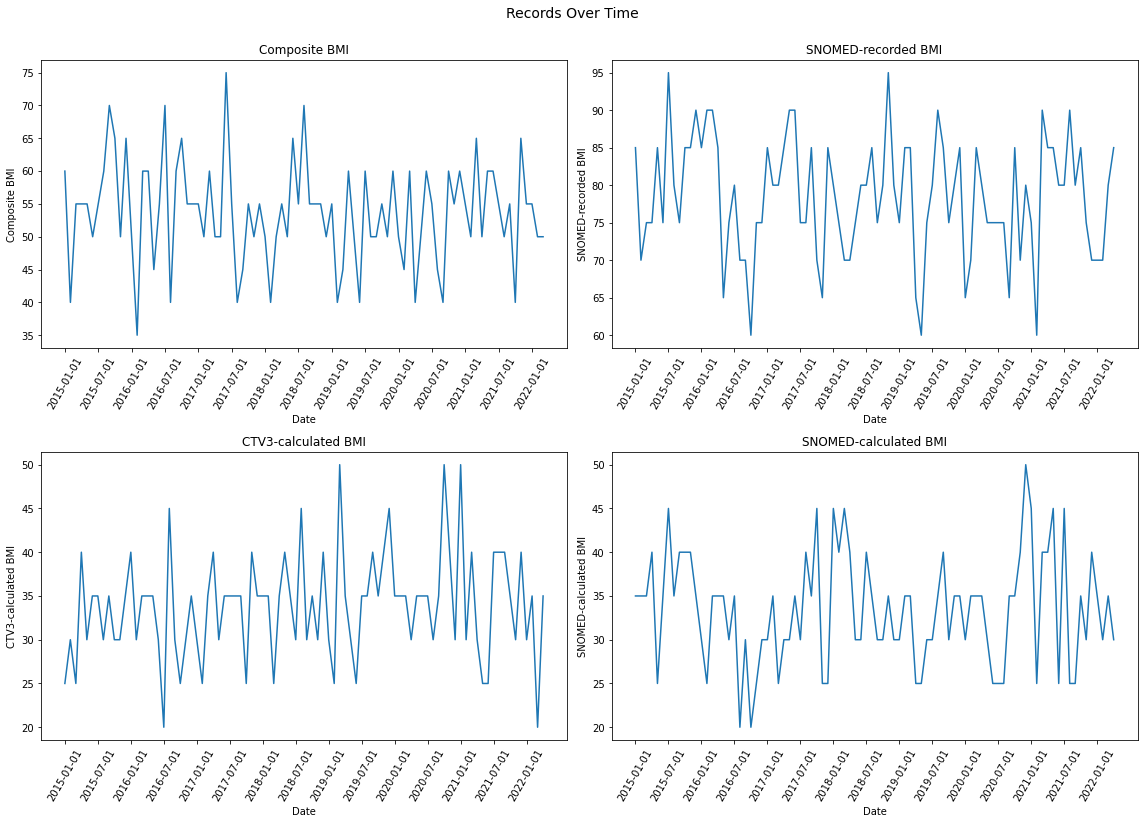

In [37]:
plot_over_time("records")

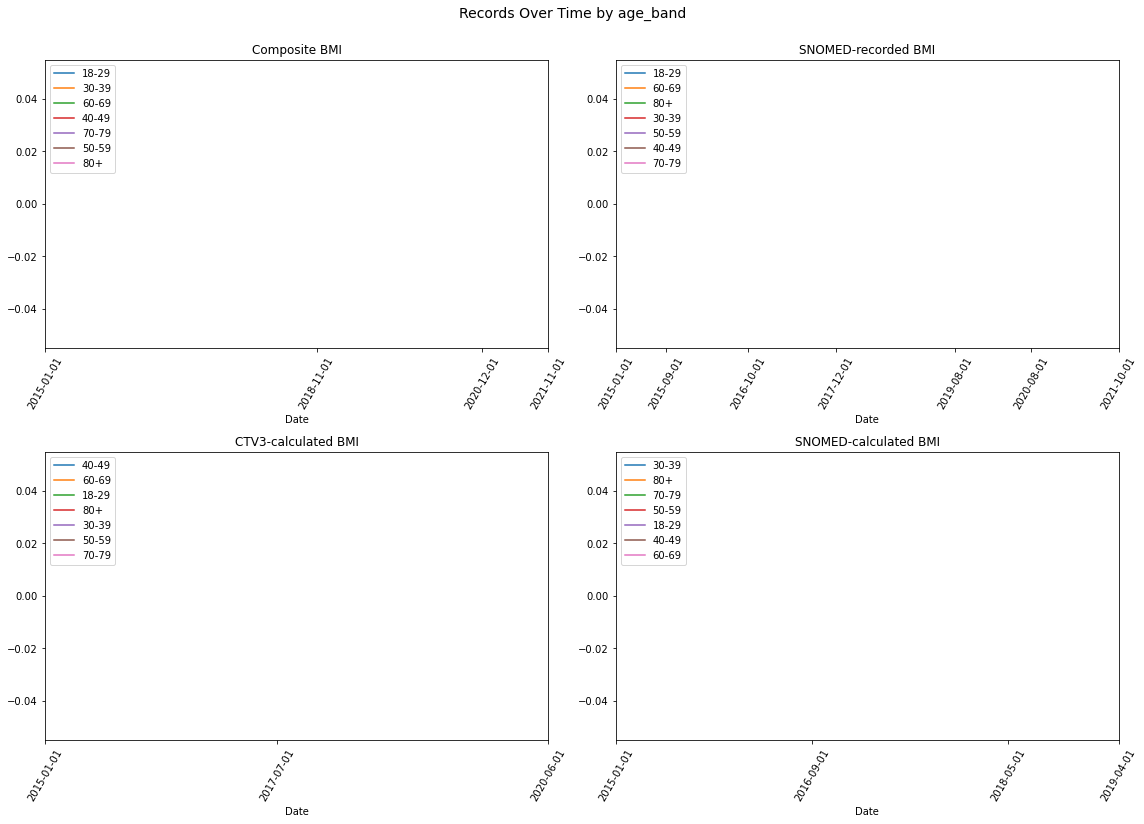

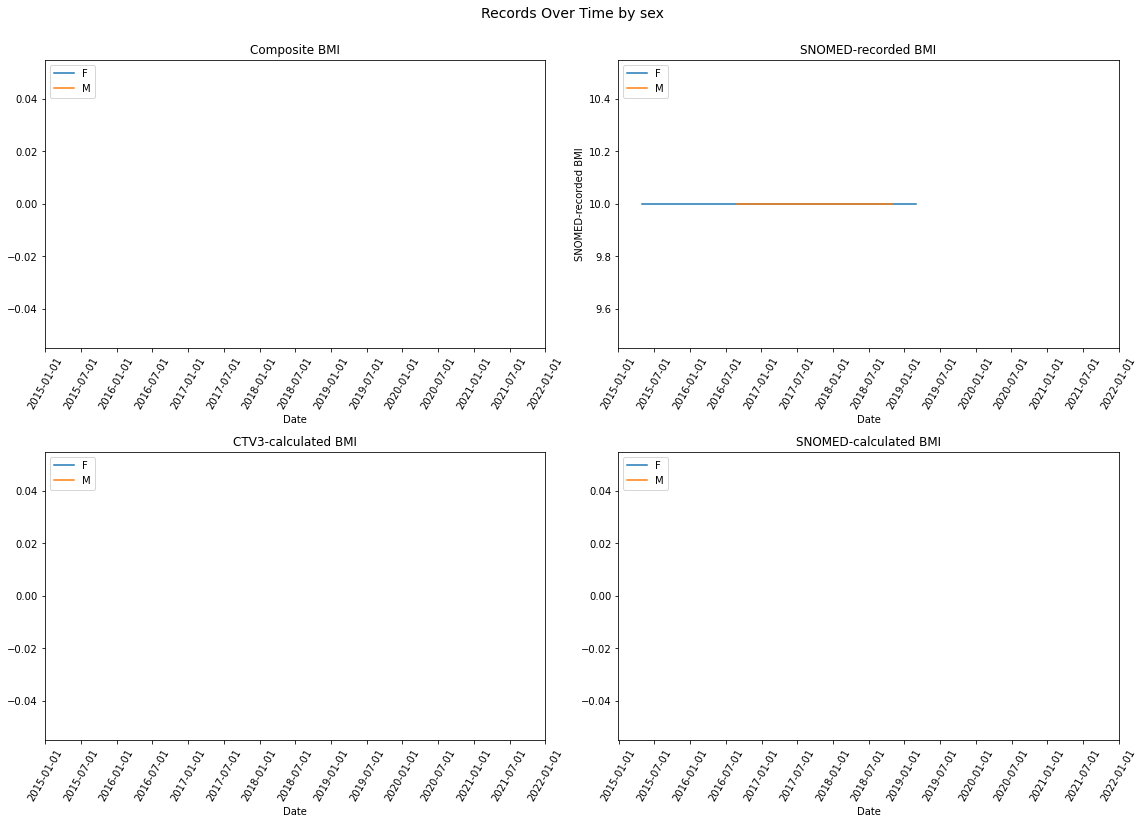

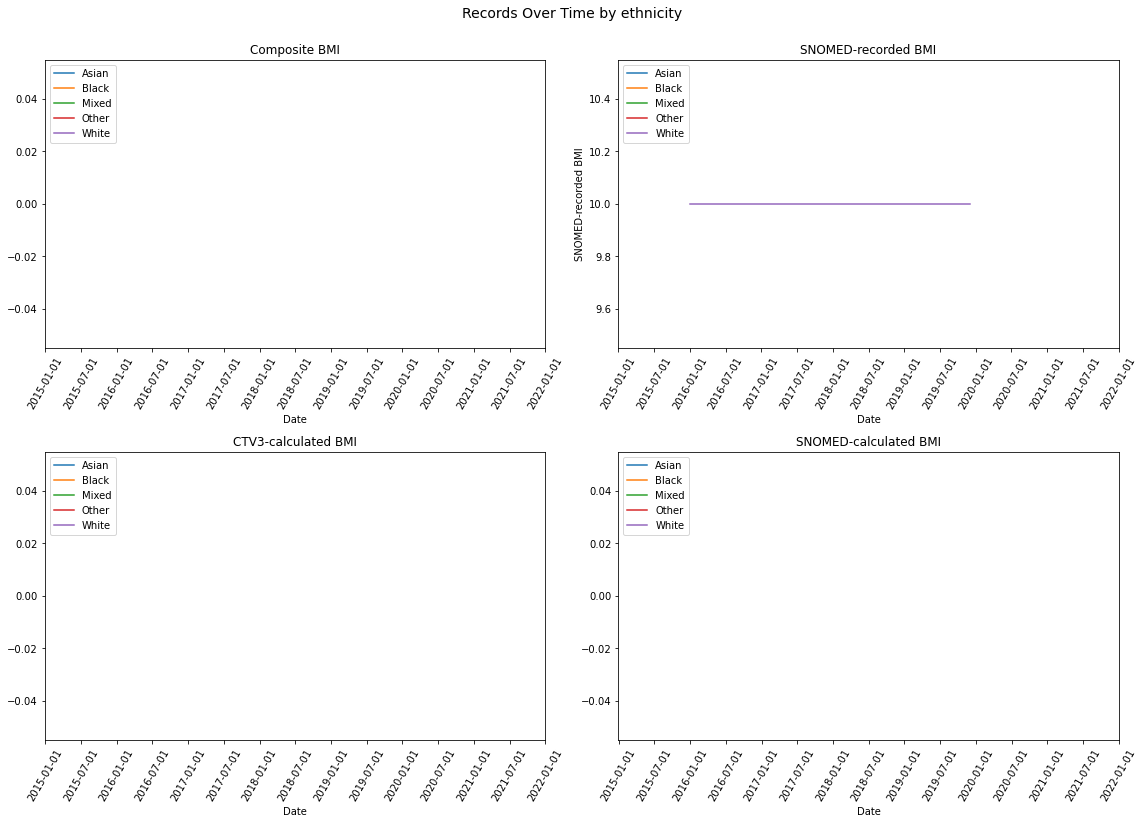

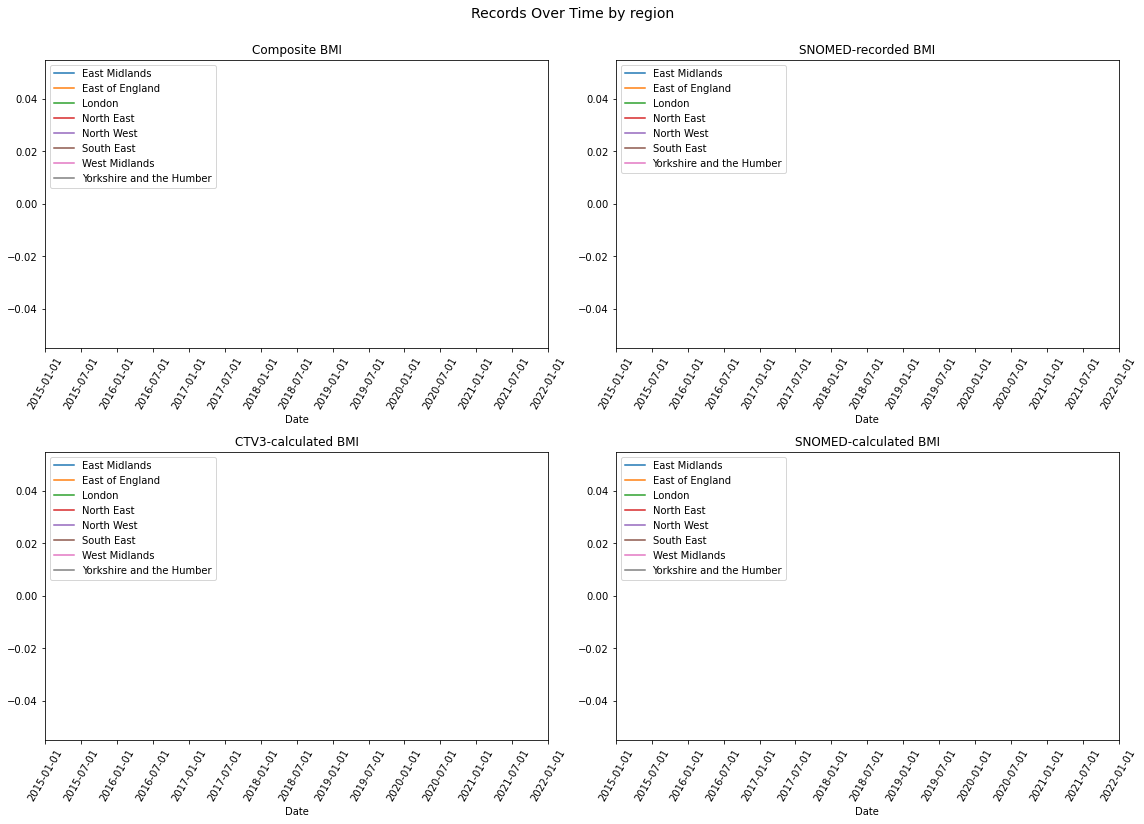

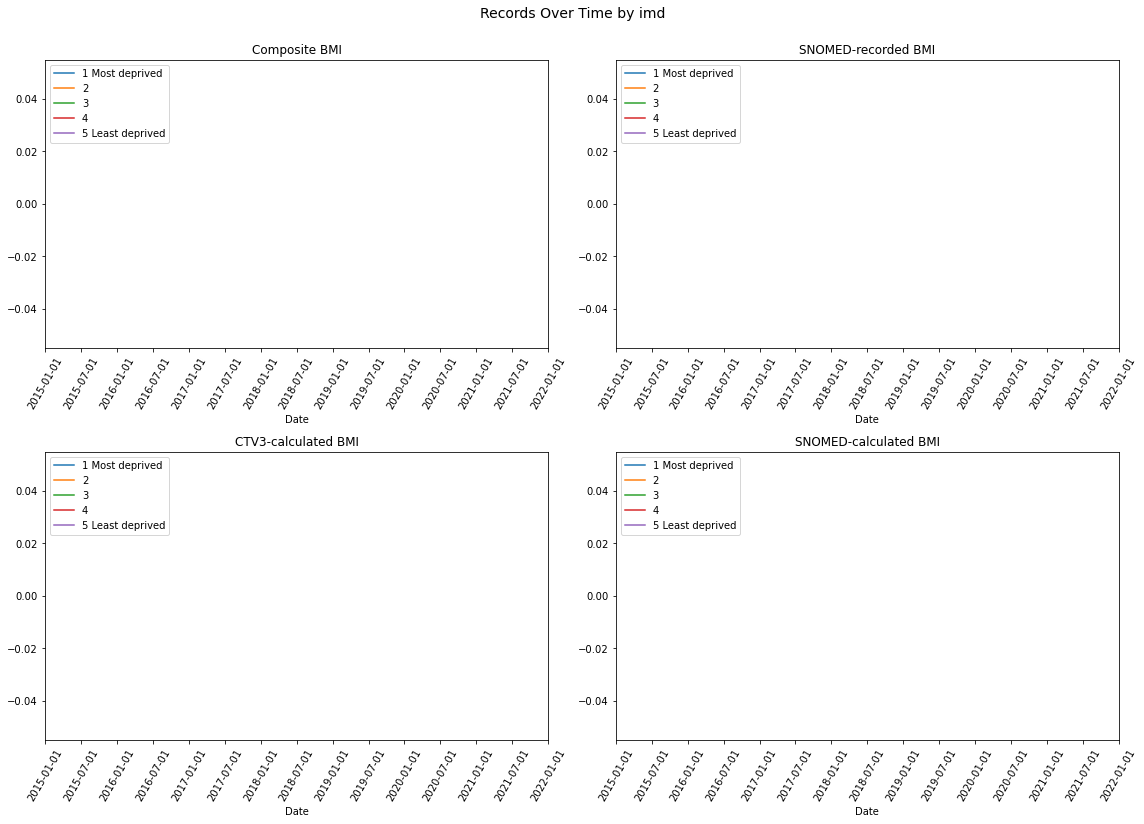

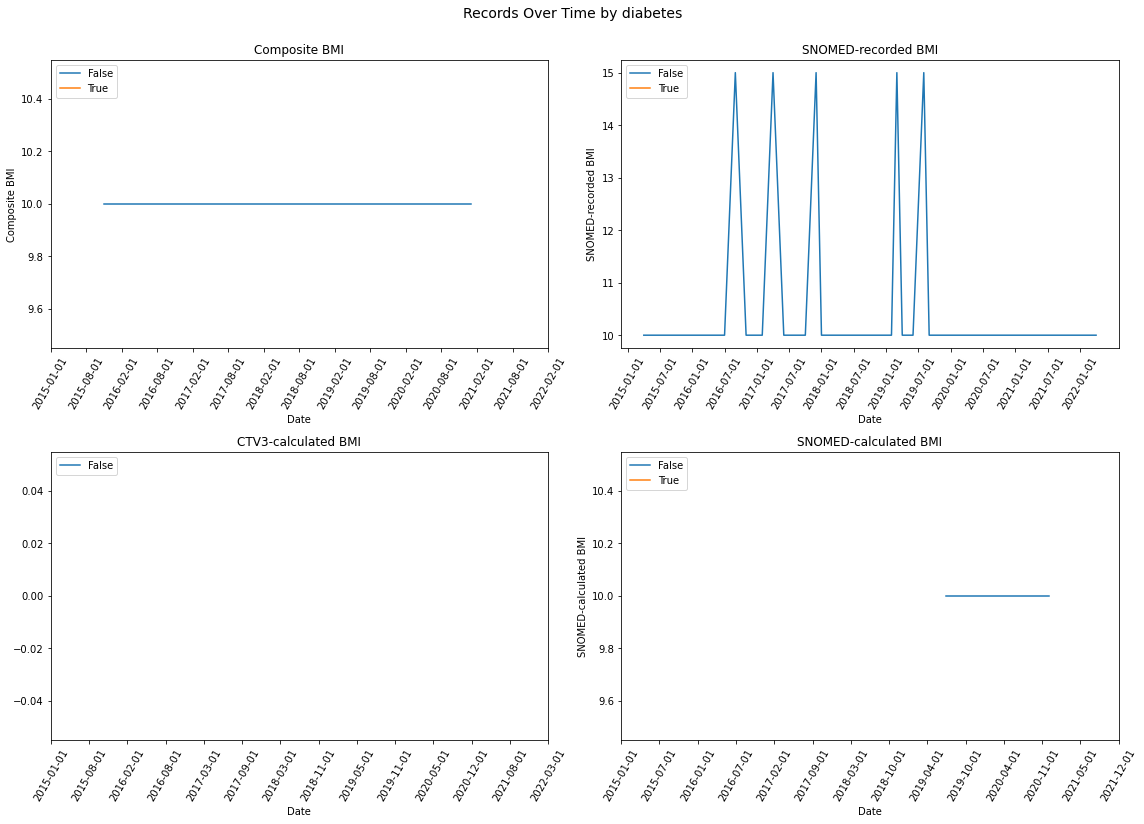

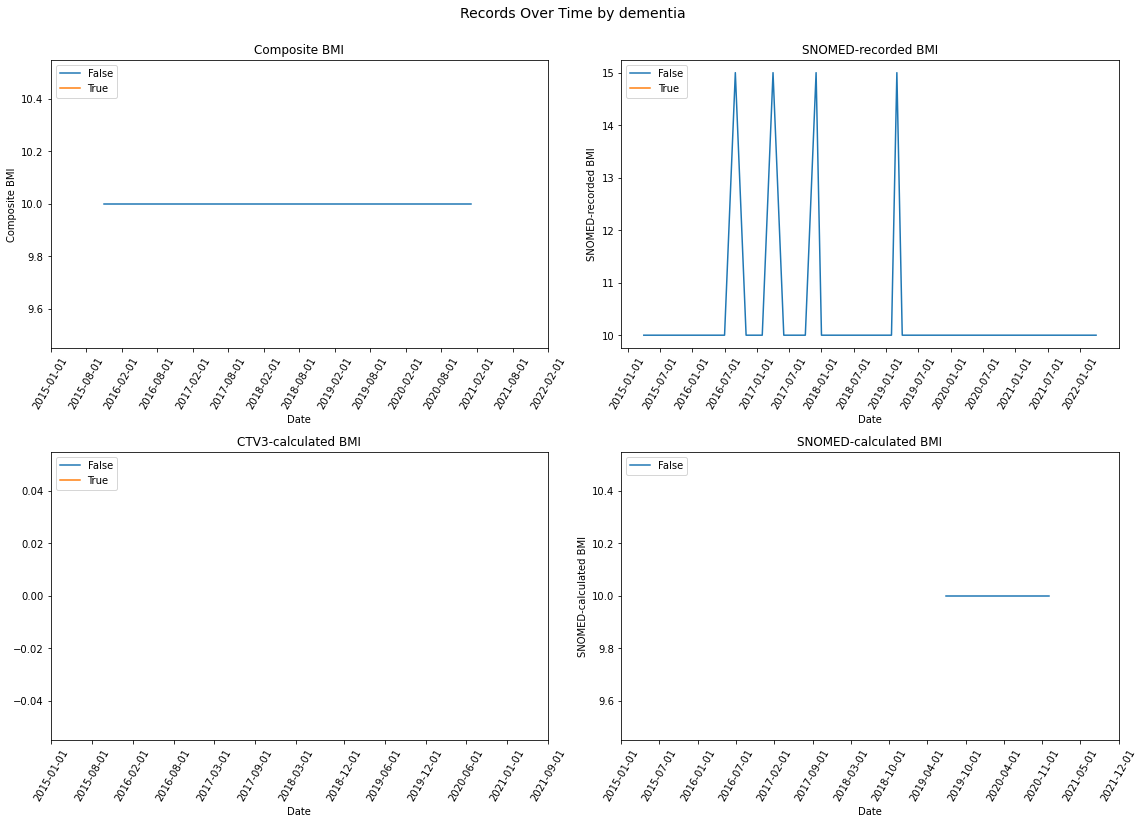

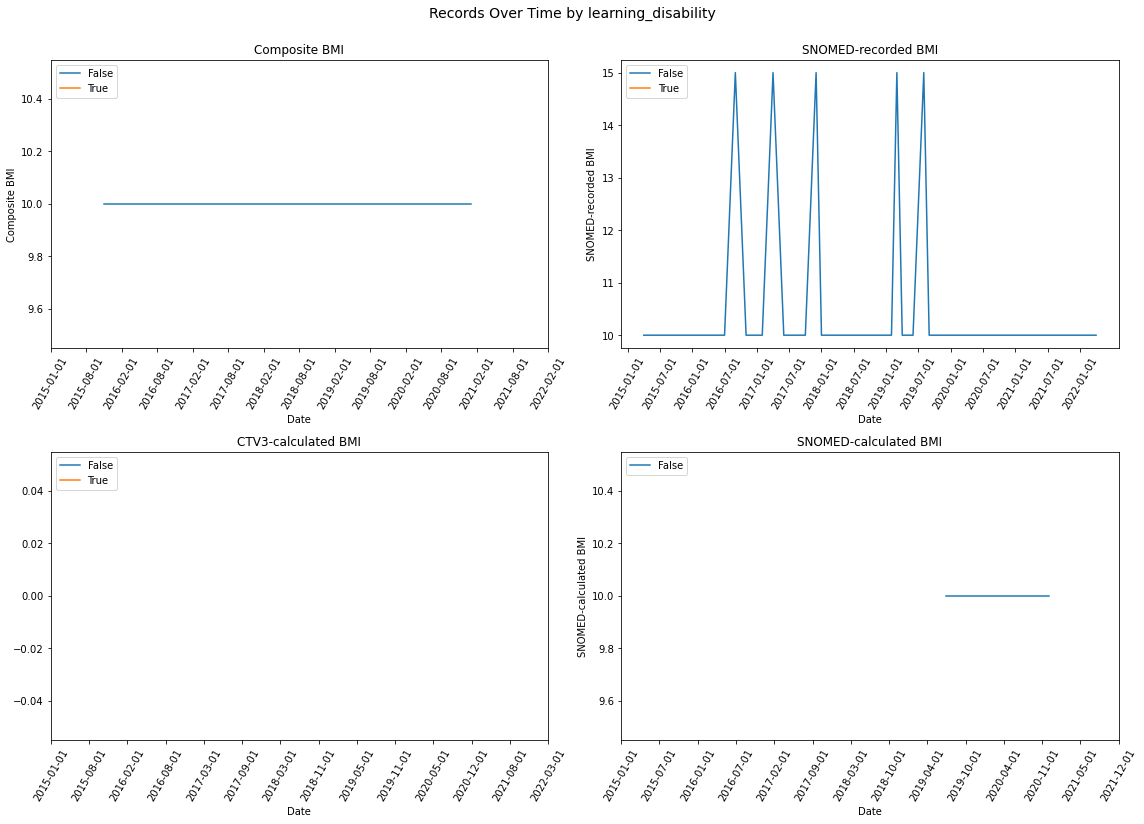

In [38]:
plot_over_time_by_group("records","age_band")
plot_over_time_by_group("records","sex")
plot_over_time_by_group("records","ethnicity", ethnicity_dict)
plot_over_time_by_group("records","region")
plot_over_time_by_group("records","imd", imd_dict)
plot_over_time_by_group("records","diabetes")
plot_over_time_by_group("records","dementia")
plot_over_time_by_group("records","learning_disability")

### Out-of-range Values

The means for CTV3-calculated and SNOMED-calculated BMI derivations by month were often unexpectedly high, with spikes at particular time points. For instance, the mean SNOMED-calculated BMI was 1.8 million in July 2015. To investigate the extent to which the definitions contained unexpected BMI values, values below 4 and above 200 were counted as out-of-range values. A standard BMI chart shows values from 9 to 65, but we have chosen the end points of implausible extremes. The means of out-of-range values were also computed to gauge the magnitude of the errors.

In [39]:
def display_oob(unit,scale):
    df_ct = pd.read_csv(f"{path}/{unit}.csv", index_col=0)
    display(df_ct)
    df_ct.loc[df_ct["category"] == "population", "sort"] = 1
    
    # Rename subcategories 
    df_ct.loc[df_ct["category"] == "ethnicity", "subcategory"] = df_ct["subcategory"].map(ethnicity_dict)
    df_ct.loc[df_ct["category"] == "imd", "subcategory"] = df_ct["subcategory"].map(imd_dict)
    
    # Clean category
    df_ct["category"] = df_ct["category"].apply(lambda x: x.replace("_", " ").title())
    df_ct["subcategory"] = df_ct["subcategory"].apply(lambda x: x.replace("_", " ").title())
    df_ct.loc[df_ct["category"] == "Imd", "category"] = "IMD"
    
    # Sort 
    df_ct = df_ct.sort_values(
        by=["sort","category","subcategory"]
    ).drop(columns=["sort"]).rename(
        columns={
            "category":"Category",
            "subcategory":"Subcategory"
        }
    ).set_index(["Category","Subcategory"])
    
    df_ct = df_ct.replace("-",np.nan)
    
    # Format column values
    for col in df_ct.columns:
        if "count" in col:
            df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else round(float(x)))
            df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else "{:,.0f}".format(x))
        if scale == "greater":
            if "mean" in col:
                df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else "{:,.0f}".format(float(x)))
        if scale == "less":
            if "mean" in col:
                df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else round(float(x),2))
                
                
    df_ct = df_ct.fillna("-")

    df_ct = df_ct.rename(
        columns = {
            "count_derived_bmi":"Composite BMI Count",
            "mean_derived_bmi":"Composite BMI Mean",
            "count_recorded_bmi":"SNOMED-recorded BMI Count",
            "mean_recorded_bmi":"SNOMED-recorded BMI Mean",
            "count_computed_bmi":"SNOMED-calculated BMI Count",
            "mean_computed_bmi":"SNOMED-calculated BMI Mean",
            "count_backend_computed_bmi":"CTV3-calculated BMI Count",
            "mean_backend_computed_bmi":"CTV3-calculated BMI Mean",
        }                       
    )
        
    display(df_ct)

In [40]:
def oob_values(unit,scale):
    global df_ct   
    df_ct = pd.read_csv(f"{path}/{unit}.csv", index_col=0)
    df_ct.loc[df_ct["category"] == "population", "sort"] = 1
    
    # Rename subcategories 
    df_ct.loc[df_ct["category"] == "ethnicity", "subcategory"] = df_ct["subcategory"].map(ethnicity_dict)
    df_ct.loc[df_ct["category"] == "imd", "subcategory"] = df_ct["subcategory"].map(imd_dict)
    
    
    df_ct = df_ct.replace("-",np.nan)
    
    # Format column values
    for col in df_ct.columns:
        if "count" in col:
            df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else round(float(x)))
            df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else "{:,.0f}".format(x))
        if scale == "greater":
            if "mean" in col:
                df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else "{:,.0f}".format(float(x)))
        if scale == "less":
            if "mean" in col:
                df_ct[col] = df_ct[col].apply(lambda x: np.nan if pd.isnull(x) else round(float(x),2))

In [41]:
oob_values("less_than_min","less")

#### Less than Minimum (BMI < 4)

In [42]:
snomed_calc_mean = df_ct["mean_computed_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()
ctv3_calc_mean = df_ct["mean_backend_computed_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()
snomed_record_mean = df_ct["mean_recorded_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()
composite_mean = df_ct["mean_derived_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()

diab_snomed_calc_mean = df_ct["mean_computed_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()
diab_ctv3_calc_mean = df_ct["mean_backend_computed_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()
diab_snomed_record_mean = df_ct["mean_recorded_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()
diab_composite_mean = df_ct["mean_derived_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()


display(Markdown(f"""
The table below summarises BMI below the minimum threshold (BMI < 4). 0.1% of composite BMI and SNOMED-recorded BMI values were below the minimum threshold (less than 4). 0.2% of CTV3-calculated BMI and 0.2% of SNOMED-calculated BMI were less than the threshold. The mean of low values in the two calculated BMI derivations (SNOMED: {snomed_calc_mean}, CTV3: {ctv3_calc_mean}) are greater than the mean of low values in the composite ({composite_mean}) or SNOMED-recorded BMI ({snomed_record_mean}) derivations. This pattern was mote pronounced in patients with diabetes (SNOMED: {diab_snomed_calc_mean}, CTV3: {diab_ctv3_calc_mean},composite {diab_composite_mean}, SNOMED-recorded BMI ({diab_snomed_record_mean}))
"""))


ValueError: can only convert an array of size 1 to a Python scalar

In [43]:
display_oob("less_than_min","less")

,category,subcategory,count_derived_bmi,mean_derived_bmi,count_recorded_bmi,mean_recorded_bmi,count_backend_computed_bmi,mean_backend_computed_bmi,count_computed_bmi,mean_computed_bmi
0,imd,0,-,-,-,-,-,-,NaN,NaN
1,imd,1,-,-,-,-,-,-,-,-
2,imd,2,-,-,-,-,-,-,-,-
3,imd,3,-,-,-,-,-,-,-,-
4,imd,4,-,-,-,-,-,-,-,-
5,imd,5,-,-,-,-,-,-,-,-
6,population,all,10.0,0.08751222813623373,-,-,-,-,-,-
7,age_band,missing,10.0,0.08751222813623373,NaN,NaN,NaN,NaN,NaN,NaN
8,region,East Midlands,-,-,-,-,-,-,-,-
9,region,East of England,-,-,-,-,-,-,-,-


Composite BMI Count Composite BMI Mean  \
Category   Subcategory                                                       
Population All                                       10               0.09   
Age Band   Missing                                   10               0.09   
Ethnicity  Asian                                      -                  -   
           Black                                      -                  -   
           Mixed                                      -                  -   
           Other                                      -                  -   
           White                                      -                  -   
IMD        1 Most Deprived                            -                  -   
           2                                          -                  -   
           3                                          -                  -   
           4                                          -                  -   
           5 Least Deprived                           -                  -   
           Unknown                                    -                  -   
Region     East Midlands                              -                  -   
           East Of England                            -                  -   
           London                                     -                  -   
           North East                                 -                  -   
           North West                                 -                  -   
           South East                                 -                  -   
           West Midlands                              -                  -   
           Yorkshire And The Humber                   -                  -   
Sex        F                                          -                  -   
           M                                          -                  -   

                                    SNOMED-recorded BMI Count  \
Category   Subcategory                                          
Population All                                              -   
Age Band   Missing                                          -   
Ethnicity  Asian                                            -   
           Black                                            -   
           Mixed                                            -   
           Other                                            -   
           White                                            -   
IMD        1 Most Deprived                                  -   
           2                                                -   
           3                                                -   
           4                                                -   
           5 Least Deprived                                 -   
           Unknown                                          -   
Region     East Midlands                                    -   
           East Of England                                  -   
           London                                           -   
           North East                                       -   
           North West                                       -   
           South East                                       -   
           West Midlands                                    -   
           Yorkshire And The Humber                         -   
Sex        F                                                -   
           M                                                -   

                                    SNOMED-recorded BMI Mean  \
Category   Subcategory                                         
Population All                                             -   
Age Band   Missing                                         -   
Ethnicity  Asian                                           -   
           Black                                           -   
           Mixed                                           -   
           

#### Greater than Maximum (BMI > 200)

The table below summarises BMI above the maximum threshold (BMI > 200). 0.1% of composite BMI, 0.007% of recorded BMI, 0.2% of CTV3-calculated BMI, and 0.2% of SNOMED-calculated BMI were greater than 200. The mean of high values in the two calculated BMI derivations (159 million) are three orders of magnitude greater than the mean of high values in the composite (274,133) or SNOMED-recorded BMI (552,825) derivations. 

In [44]:
oob_values("less_than_min","greater")

In [47]:
snomed_calc_mean = df_ct["mean_computed_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()
ctv3_calc_mean = df_ct["mean_backend_computed_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()
snomed_record_mean = df_ct["mean_recorded_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()
composite_mean = df_ct["mean_derived_bmi"].loc[(df_ct['category'] == "population") & (df_ct['subcategory'] == "all")].item()

diab_snomed_calc_mean = df_ct["mean_computed_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()
diab_ctv3_calc_mean = df_ct["mean_backend_computed_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()
diab_snomed_record_mean = df_ct["mean_recorded_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()
diab_composite_mean = df_ct["mean_derived_bmi"].loc[(df_ct['category'] == "diabetes") & (df_ct['subcategory'] == "True")].item()


display(Markdown(f"""
The table below summarises BMI above the maximum threshold (BMI > 200). 0.1% of composite BMI, 0.007% of recorded BMI, 0.2% of CTV3-calculated BMI, and 0.2% of SNOMED-calculated BMI were greater than 200. The mean of high values in the two calculated BMI derivations (SNOMED: {snomed_calc_mean}, CTV3: {ctv3_calc_mean}) are greater than the mean of high values in the composite ({composite_mean}) or SNOMED-recorded BMI ({snomed_record_mean}) derivations. In patients with diabetes the mean of high values in the two calculated BMI derivations ({diab_snomed_calc_mean}, {diab_ctv3_calc_mean}) are three orders of magnitude greater than the mean of high values in the composite ({diab_composite_mean}) or SNOMED-recorded BMI ({diab_snomed_record_mean}) derivations
"""))

ValueError: can only convert an array of size 1 to a Python scalar

In [46]:
display_oob("greater_than_max","greater")

,category,subcategory,count_derived_bmi,mean_derived_bmi,count_recorded_bmi,mean_recorded_bmi,count_backend_computed_bmi,mean_backend_computed_bmi,count_computed_bmi,mean_computed_bmi
0,region,East Midlands,-,-,-,-,-,-,-,-
1,region,East of England,-,-,-,-,-,-,-,-
2,region,London,-,-,-,-,-,-,-,-
3,region,North East,-,-,-,-,-,-,-,-
4,region,North West,-,-,-,-,-,-,-,-
5,region,South East,-,-,-,-,-,-,-,-
6,region,West Midlands,-,-,NaN,NaN,-,-,-,-
7,region,Yorkshire and the Humber,-,-,-,-,-,-,-,-
8,imd,0,-,-,-,-,-,-,NaN,NaN
9,imd,1,-,-,-,-,-,-,-,-


Composite BMI Count Composite BMI Mean  \
Category   Subcategory                                                       
Population All                                        -                  -   
Ethnicity  Asian                                      -                  -   
           Black                                      -                  -   
           Mixed                                      -                  -   
           Other                                      -                  -   
           White                                      -                  -   
IMD        1 Most Deprived                            -                  -   
           2                                          -                  -   
           3                                          -                  -   
           4                                          -                  -   
           5 Least Deprived                           -                  -   
           Unknown                                    -                  -   
Region     East Midlands                              -                  -   
           East Of England                            -                  -   
           London                                     -                  -   
           North East                                 -                  -   
           North West                                 -                  -   
           South East                                 -                  -   
           West Midlands                              -                  -   
           Yorkshire And The Humber                   -                  -   
Sex        F                                          -                  -   
           M                                          -                  -   

                                    SNOMED-recorded BMI Count  \
Category   Subcategory                                          
Population All                                              -   
Ethnicity  Asian                                            -   
           Black                                            -   
           Mixed                                            -   
           Other                                            -   
           White                                            -   
IMD        1 Most Deprived                                  -   
           2                                                -   
           3                                                -   
           4                                                -   
           5 Least Deprived                                 -   
           Unknown                                          -   
Region     East Midlands                                    -   
           East Of England                                  -   
           London                                           -   
           North East                                       -   
           North West                                       -   
           South East                                       -   
           West Midlands                                    -   
           Yorkshire And The Humber                         -   
Sex        F                                                -   
           M                                                -   

                                    SNOMED-recorded BMI Mean  \
Category   Subcategory                                         
Population All                                             -   
Ethnicity  Asian                                           -   
           Black                                           -   
           Mixed                                           -   
           Other                                           -   
           White                                           -   
IMD        1 Most Deprived                                 -   
           2              

#### Empirical Cumulative Distribution Functions (CDF) of BMI Values

As the CDF plots of each derivation show, nearly all measurements fall between 15 and 45 across all definitions. This indicates that the spike in means can be attributed to few extreme outliers. 

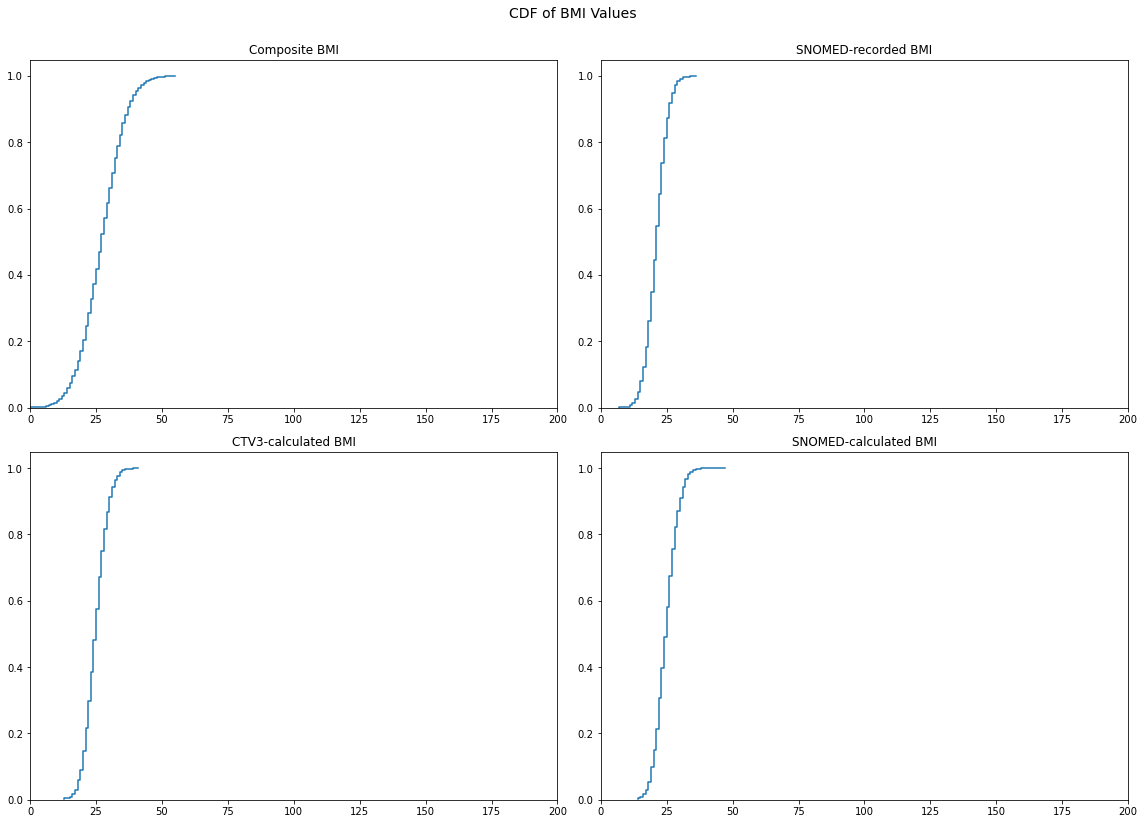

In [ ]:
i = 0
N = 4
cols = 2
rows = int(math.ceil(N / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()

for bmi in ["derived_bmi", "recorded_bmi", "backend_computed_bmi", "computed_bmi"]:
    file = f"{path2}/{bmi}/{bmi}_cdf_data.csv"
    df_temp = pd.read_csv(file,index_col=0)
    definition = df_temp.columns[0]
    
    # Rename labels 
    if definition == "derived_bmi":
        definition2 = "Composite BMI"
    elif definition == "recorded_bmi": 
        definition2 = "SNOMED-recorded BMI"
    elif definition == "computed_bmi":
        definition2 = "SNOMED-calculated BMI"
    else:
        definition2 = "CTV3-calculated BMI"
    
    ax = fig.add_subplot(gs[i])
    ax.step(x = definition, y = 'cdf', data=df_temp)
    plt.ylim(bottom=0)
    plt.xlim(0,200)
    ax.set_title(f'{definition2}')
    i += 1
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"CDF of BMI Values", fontsize=14)
plt.show()

#### Height and Weight CDFs for High Calculated BMI Values

To highlight the source of the high calculated BMI values, we investigate the height and weights of high BMI results. While the weights are mostly in a reasonable range, most of the heights associated with high calculated BMI values range between -1 and 1. Since the formula to compute BMI is `weight (kg)/(height (m)^2)`, fractional height values would result in very high BMI values.

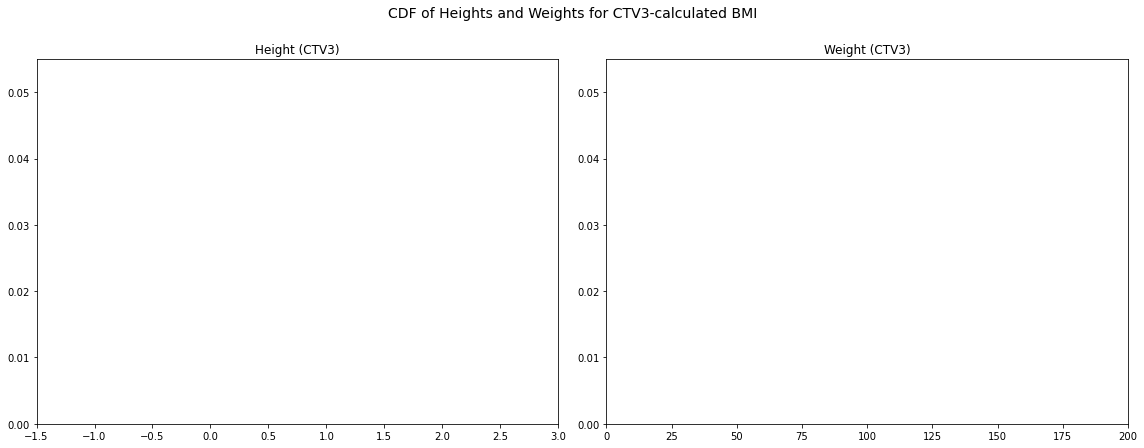

In [ ]:
path2 = "../output/validation/tables"

i = 0
N = 4
cols = 2
rows = int(math.ceil(N / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()

for file in glob.glob(f"{path2}/high_backend_computed_bmi/*eight_backend_cdf_data.csv"):
    df_temp = pd.read_csv(file, index_col=0)
    definition = df_temp.columns[0]
    ax = fig.add_subplot(gs[i])
    ax.step(x = definition, y = 'cdf', data=df_temp)
    if "height" in file:
        plt.xlim(-1.5,3)
    else:
        plt.xlim(0,200)
    plt.ylim(bottom=0)

    # Rename labels 
    if definition == "height_backend":
        definition2 = "Height (CTV3)"
    else:
        definition2 = "Weight (CTV3)"

    ax.set_title(f'{definition2}')
    i += 1

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"CDF of Heights and Weights for CTV3-calculated BMI", fontsize=14)
plt.show()

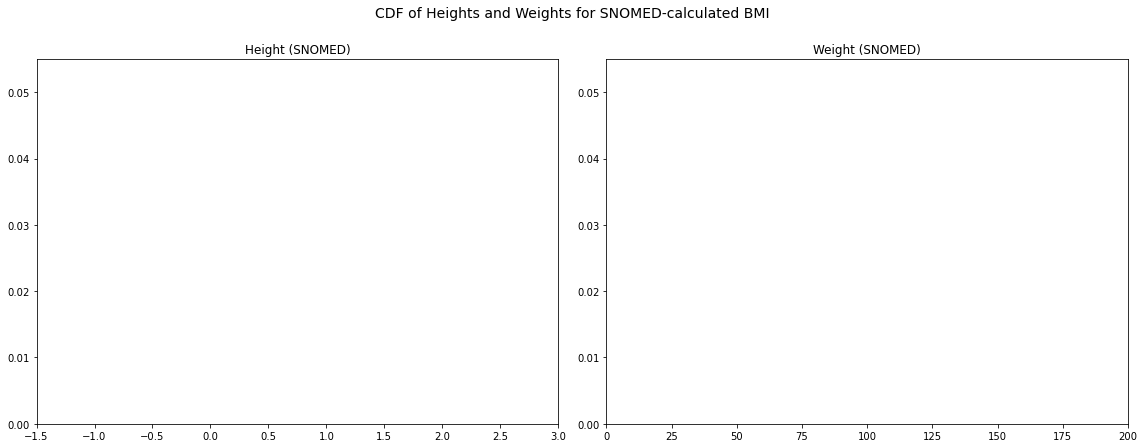

In [ ]:
i = 0
N = 4
cols = 2
rows = int(math.ceil(N / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()

for file in glob.glob(f"{path2}/high_computed_bmi/*eight_cdf_data.csv"):
    df_temp = pd.read_csv(file, index_col=0)
    definition = df_temp.columns[0]
    ax = fig.add_subplot(gs[i])
    ax.step(x = definition, y = 'cdf', data=df_temp)
    if "height" in file:
        plt.xlim(-1.5,3)
    else:
        plt.xlim(0,200)
    plt.ylim(bottom=0)

    # Rename labels 
    if definition == "height":
        definition2 = "Height (SNOMED)"
    elif definition == "weight": 
        definition2 = "Weight (SNOMED)"

    ax.set_title(f'{definition2}')
    i += 1

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"CDF of Heights and Weights for SNOMED-calculated BMI", fontsize=14)
plt.show()

#### High Calculated BMI Over Time

Looking at high calculated BMIs by month shows that the prevalence of implausibly high values are decreasing over time.

In [ ]:
def high_plot_over_time(unit):
    i = 0
    N = 4
    cols = 2
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()

    for file in glob.glob(f"{path}/high_*{unit}_over_time.csv"):
        if "high" in file:
            df_in = pd.read_csv(file)
            if len(df_in) > 0:
                definition  = file.rsplit('/', 1)[-1].rsplit(f'_{unit}', 1)[0]
                df_sub = df_in.loc[df_in["category"] == "population"]
                df_sub = df_sub.loc[df_sub["date"] != "2022-05-01"]

                # Rename labels 
                if definition == "high_computed_bmi":
                    definition2 = "SNOMED-calculated BMI"
                else:
                    definition2 = "CTV3-calculated BMI"
                df_sub = df_sub.rename(columns={"date":"Date"})

                ax = fig.add_subplot(gs[i]) 

                if unit == "records":
                    df_sub = df_sub.rename(columns={f"{definition}": f"{definition2}"})
                    df_sub[f"{definition2}"] = df_sub[f"{definition2}"].astype(float)
                    ax = sns.lineplot(x="Date", y=f"{definition2}", data=df_sub)
                    ax.set_title(f"{definition2}")
                else:
                    df_sub["mean"] = df_sub["mean"].astype(float)
                    ax = sns.lineplot(x="Date", y="mean", data=df_sub)
                    ax.set_title(f"{definition2}")

                i += 1
                l = plt.xticks(df_sub["Date"][0::6])
                plt.xticks(rotation=60)
            else: 
                print("No observations to be plotted.")

            
    unit2 = unit.title()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"{unit2} of High Calculated BMI", fontsize=14)
    plt.show()  

In [ ]:
high_plot_over_time("records")

<Figure size 1152x864 with 0 Axes>

## Discussion

There are three primary constraints in creating the optimal BMI derivation: coverage, accuracy, and computational complexity.

**Coverage:** While all four derivations are similar in the number of patients they cover, composite BMI captures the most number of measurements as it combines CTV3-calculated and SNOMED-recorded BMI definitions.

**Accuracy:** The two calculated BMI definitions contain more erroneous, implausible outliers that affect aggregated statistics such as means. While the recorded BMI derivation has 12 million fewer records than composite BMI, it contains fewer extreme outliers than the calculated BMI measurements.

**Computational complexity:** The `most_recent_bmi()` function (used to derive composite BMI) is resource-intensive to run as it executes complex SQL queries to use CTV3-calculated BMI in the first instance, and when CTV3-calculated BMI is missing, use recorded BMI.

Taking these three constraints into account, there are two recommended solutions to create a consistent derivation of BMI in OpenSAFELY-TPP:

1. Use SNOMED-recorded BMI, dropping values that fall out of the expected range. This will offer reasonably good coverage, good accuracy with minimal cleaning, and reduce computational complexity.

2. Clean both the CTV3-calculated and SNOMED-recorded BMI definitions before they are combined to create composite BMI. This will require additional configuration in the backend, which may increase computational complexity, but this method will offer the maximum possible coverage of measurements. 

Using either derivation of calculated BMI on its own does not offer the best coverage or accuracy. The results also show that the two calculated BMI definitions are negligibly different from each other; hence, the CTV3 and SNOMED height and weight codes can be used interchangeably to calculate BMI.

### Limitations

It is not possible to extract event-level data in the current implementation of OpenSAFELY-TPP. As a result, coded events can only be extracted as single values in a time period. This study extracts 10 BMI values per patient based on a preliminary analysis that showed that, on average, each patient has 6 or 7 recorded BMI measurements. 

Due to server memory constraints, the covariates are constrained to extraction at a set index date (1st May 2022), rather than at the time of the event record. The covariates are adjusted to the time of measurement where possible (e.g. age is adjusted to the age at measurement date, based on the patient's birthday). However, this is more difficult for factors that may change unpredictably over time (e.g. region or IMD) or for more transient clinical conditions (e.g. hypertension). 

Another issue posed by the memory constraints is the lack of cross-checks. Each derivation is analysed in separate scripts. Hence, there are no contingency tables (frequency tables showing correlations between definitions) or other analyses that describe overlap between the different derivations.

It should also be noted that patients who have not had a measurement show a value of 0 in the records. Because it is not possible to differentiate those who have not had a measurement from those whose measurement was recorded as 0, all 0-valued BMI records were excluded from the above analyses. As any true adult BMI should be greater than 0 (the minimum threshold we use for plausible values is 4), BMI values of 0 should be excluded from analyses regardless. 

## Conclusion

This report describes existing methods to derive BMI in OpenSAFELY-TPP and suggests improvements to the standard method. It is a living document that can be periodically re-run to evaluate the most current best practices for research. If you have improvements or forks, please contact the OpenSAFELY data team. 

## Reference

1. Du Y, Lv Y, Zha W, Zhou N, Hong X. Association of body mass index (BMI) with critical COVID-19 and in-hospital mortality: A dose-response meta-analysis. Metabolism. 2021;117: 154373.
2. 	Kim TS, Roslin M, Wang JJ, Kane J, Hirsch JS, Kim EJ, et al. BMI as a Risk Factor for Clinical Outcomes in Patients Hospitalized with COVID-19 in New York. Obesity. 2021;29: 279-284.
3. 	Soeroto AY, Soetedjo NN, Purwiga A, Santoso P, Kulsum ID, Suryadinata H, et al. Effect of increased BMI and obesity on the outcome of COVID-19 adult patients: A systematic review and meta-analysis. Diabetes Metab Syndr. 2020;14: 1897-1904.